## Homework 2  - Questions 5 and 6: model comparisons
Michelle Hu  
---
University of Washington  
AMATH 563  
Due: May 6, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.integrate import solve_ivp

from scipy.special import rel_entr

In [3]:
wd = "/mnt/Backups/jmhu"
data_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/data/"
model_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/models/"
fig_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/figures/"

#### Define functions

In [4]:
def lotka_volterra(t, x0, b, p, r, d):
    '''Empirical Lotka-Volterra predator-prey model'''
    x, y = x0
    xdot = (b - p*y) * x
    ydot = (r*x - d) * y
    
    return(xdot, ydot)


def densify(t, y, dt):
    '''Point interpolation'''
    from scipy.interpolate import interp1d
    
    f = interp1d(t, y, kind='cubic')
    tnew = np.arange(t[0], t[-1], dt)
    ynew = f(tnew)
    
    return(tnew, ynew)


def setup_problem(df, make_it_dense=5):
    '''Prepare matrices'''
    X=df.Hare.values
    Y=df.Lynx.values

    t = df.Year.values
    dt = (t[1] - t[0])/make_it_dense # make 5 times more points

    # Interpolate for more points
    years, X = densify(t, X, dt)
    years, Y = densify(t, Y, dt)
    
    return X, Y, years


def get_predictions(X, Y, years, Xi_coef, Yi_coef, model=lotka_volterra):    
    '''Find initial value problem solutions for input model, coefficients and time range'''
    t_range = [0, len(years)] 
    x0 = (X[0], Y[0])

    # Extract coefficients
    b, p = np.abs(Xi_coef)
    d, r = np.abs(Yi_coef)
    
    sol = solve_ivp(model, t_range, x0, 
                    args=(b, p, r, d), dense_output=True)

    t = np.arange(0, len(years), 1)
    predictions = sol.sol(t)

    return t, predictions


def get_predictions_SINDy(X, Y, years, coefs, model):    
    '''Find initial value problem solutions for input model, coefficients and time range'''
    t_range = [0, len(years)] 
    x0 = (X[0], Y[0])
    
    sol = solve_ivp(model, t_range, x0, 
                    args=(np.array(coefs)), dense_output=True)

    t = np.arange(0, len(years), 1)
    predictions = sol.sol(t)

    return t, predictions

### Load data

In [5]:
def fn_list(thisDir, fn_pattern):
    '''
    Function that returns a sorted list of filenames based on a regex pattern in specified directory
    '''
    fns=[]
    import glob

    for f in glob.glob(thisDir + "/" + fn_pattern): 
        fns.append(f)
    fns.sort()
    
    return fns

In [6]:
df = pd.read_csv(data_dir+"population_data.csv")
df.head()

,Year,Hare,Lynx
0,1845,20,32
1,1847,20,50
2,1849,52,12
3,1851,83,10
4,1853,64,13


### Load DMD models

In [7]:
DMD_fns = fn_list(model_dir, "*DMD*5pts*")
print(DMD_fns)

DMD_models = []
for DMD_fn in DMD_fns:
    with open(DMD_fn, 'rb') as file:
        DMD = pickle.load(file)
        DMD_models.append(DMD)
        
# Phi_disk, b_disk, Omega_disk, r_disk       
DMD, DMD_H_hare, DMD_H_lynx = DMD_models

['/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/DMD_5pts.pkl', '/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/DMD_H_hare_5pts.pkl', '/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/DMD_H_lynx_5pts.pkl']


#### Reconstruct with forecast function

In [8]:
def forecast(Phi, Omega, t, b, r, dt):
    u_modes = np.zeros((r, t))
    time_vector = dt*np.arange(-1, t-1)
    for i in np.arange(0, t):
        u_modes[:, i]=b * np.exp(Omega * time_vector[i])
    Xdmd = Phi @ u_modes
    print(t, u_modes.shape, time_vector.shape, Xdmd.shape)
    return(Xdmd)

In [9]:
X, Y, years = setup_problem(df)
t = len(years)
r = 2
dt = years[1] - years[0]

[Phi, b, Omega, r] = DMD # Extract coefficients from model

# Extract DMD forecast 
Xdmd = forecast(Phi, Omega, t, b, r, dt)

145 (2, 145) (145,) (2, 145)


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


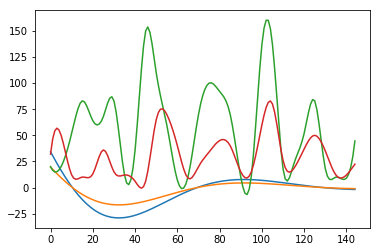

In [10]:
plt.plot(Xdmd.T[:, 0])
plt.plot(Xdmd.T[:, 1])
plt.plot(X)
plt.plot(Y);

In [11]:
# Extract coefficients from Hankel models
Phis = [DMD_H_hare[0], DMD_H_lynx[0]]
bs = [DMD_H_hare[1], DMD_H_lynx[1]]
Omegas = [DMD_H_hare[2], DMD_H_lynx[2]]
rs = [DMD_H_hare[-1], DMD_H_lynx[-1]]

In [12]:
Xdmds = []

for Phi, Omega, b, r in zip(Phis, Omegas, bs, rs):
    Xdmd_H = forecast(Phi, Omega, t, b, r, dt)
    Xdmds.append(Xdmd_H)

print(t, r, dt)

145 (21, 145) (145,) (145, 145)
145 (21, 145) (145,) (145, 145)
145 21 0.40000000000009095


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


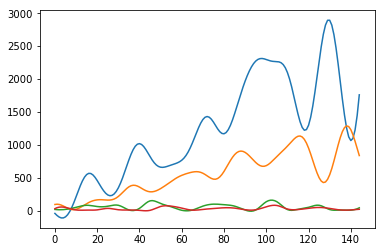

In [13]:
plt.plot(Xdmds[0].T[:, 0])
plt.plot(Xdmds[1].T[:, 1])
plt.plot(X)
plt.plot(Y);

### Load LASSO regressed coefficients and SINDy-derived Lotka-Volterra model

In [14]:
hare_model_fns=fn_list(model_dir, "lasso_LV*hare.pkl")
lynx_model_fns=fn_list(model_dir, "lasso_LV*lynx.pkl")

print(" ---- Hare models ---- ")
for h in hare_model_fns:
    print(h.split('/')[-1][:-4])

print("\n")
print(" ---- Lynx models ---- ")
for l in lynx_model_fns:
    print(l.split('/')[-1][:-4])

 ---- Hare models ---- 
lasso_LV_5pts_1_hare


 ---- Lynx models ---- 
lasso_LV_5pts_1_lynx


In [15]:
hare_models=[pickle.load(open(hare_fn, 'rb')) for hare_fn in hare_model_fns]
lynx_models=[pickle.load(open(lynx_fn, 'rb')) for lynx_fn in lynx_model_fns]

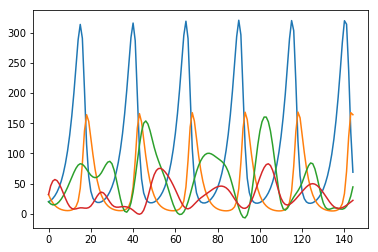

In [16]:
# Pull in LASSO_LV model coefficients
t, preds = get_predictions(X, Y, years, hare_models[0].coef_, lynx_models[0].coef_)
plt.plot(t, preds.T);
plt.plot(X)
plt.plot(Y);

### Load SINDy LV + control model

In [17]:
def lotka_volterra_control(t, x0, b, p, r, d):
    '''Empirical Lotka-Volterra predator-prey model with SINDy-derived weightings 
    and published control function from https://arxiv.org/pdf/1605.06682.pdf'''
    x, y = x0
    xdot = (b - p*y) * x + (2*np.sin(t) + 2*np.sin(t/10))**2
    ydot = (r*x - d) * y
    
    return(xdot, ydot)

In [18]:
t_control, preds_control = get_predictions(X, Y, years, 
                                           hare_models[0].coef_, 
                                           lynx_models[0].coef_,
                                           model = lotka_volterra_control
                                          )

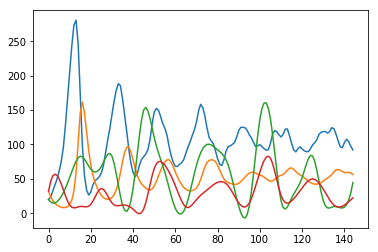

In [19]:
plt.plot(preds_control.T);
plt.plot(X)
plt.plot(Y);

### Load new SINDy model

In [20]:
def new_model(t, x0, a, b, c, d, e):
    '''SINDy model'''
    x, y = x0
    xdot = a*x + b*x*y
    ydot = c*x + d*y + e*x*y
    return(xdot, ydot)

In [21]:
SINDy_fn = fn_list(model_dir, "*SIND*")[0]
print(SINDy_fn)

with open(SINDy_fn, 'rb') as file:
    SINDy = pickle.load(file)
    
[a, b, c, d, e] = SINDy

/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw2/models/SINDy_new_5pts_thresh1kth.pkl


In [22]:
t_SINDy, preds_SINDy = get_predictions_SINDy(X, Y, years, 
                                             [a, b, c, d, e], 
                                             model = new_model)

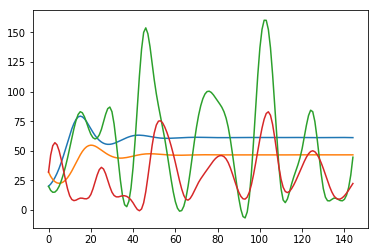

In [23]:
plt.plot(preds_SINDy.T);
plt.plot(X)
plt.plot(Y);

---
## Question 5.  Compute the KL divergence of the best model fit to the data between all the above models.
KL divergence = statistical metric representing info lost when g(x) is used to represent f(x)  
KL(f,g) = integral [ f(X,Beta) * log (f(X, Beta)/g(X, mu)) dX ]  

### Generate probability distribution functions

In [24]:
def pdf_plot(data, nbins):
    # Store bin counts, bin positions, patches returned from histogram function
    counts, bins, patches = plt.hist(data, nbins)
    plt.close() # close figure

    # get bin width from first two bin positions
    bin_width=bins[1]-bins[0]

    # get list of bin centers from bin_width - you'll need these to plot
    bin_centers=bins+bin_width/2
    bin_centers=bin_centers[:-1] # remove last entry, this is out of range
    
    # calculate bin areas based on width and histogram counts
    bin_areas=[c * bin_width for c in counts]
    
    # calculate fractional area for each bin
    bin_fractions=[bin_area/sum(bin_areas) for bin_area in bin_areas]
    
    return bin_centers, bin_fractions

# Testing
# p_centers, p_fractions = pdf_plot(preds_control[0], 10)
# q_centers, q_fractions = pdf_plot(preds_control[1], 10)

# plt.plot(p_centers, p_fractions,
#          '-', color='salmon')
# plt.plot(q_centers, q_fractions,
#          '-', color='dodgerblue')

In [25]:
def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    ### modified from https://gist.github.com/swayson/86c296aa354a555536e6765bbe726ff7
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    
    div = p*np.log(np.array(p)/np.array(q))
    div = div[~np.isnan(div)]
    div = np.sum(div)

    return np.round(div, 3)

def calc_KL(truth, predictions, bins=10):
    kl_divs=[]
    for i in range(2):
        p=predictions[i]
        q=truth[i]

        _, p_pdf = pdf_plot(p, bins)
        _, q_pdf = pdf_plot(q, bins)

        kl_divs.append(kl(p_pdf, q_pdf))
    return kl_divs

### DMD

In [26]:
DMD_preds = np.real([Xdmd.T[:, 0], Xdmd.T[:, 1]])
calc_KL([X,Y], DMD_preds)

[0.216, 0.493]

### DMD + Hankel

In [27]:
DMD_H_preds = np.real([Xdmds[0].T[:, 0], Xdmds[1].T[:, 0]])
calc_KL([X,Y], DMD_H_preds)

[0.203, 0.344]

### LASSO LV model SINDy-derived coefficients

In [28]:
calc_KL([X,Y], preds)

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


[0.317, 1.114]

### SINDy LV + Control

In [29]:
calc_KL([X,Y], preds_control)

[0.433, 0.419]

### New SINDY model and coefficients

In [30]:
calc_KL([X,Y], preds_SINDy)

[1.828, 2.241]

Larger values for KL divergence indicate more information lost when using the selected model to represent observations  
* Best overall model was DMD+Hankel (0.203 + 0.344)

### Compare best-fit overall model to all the other models (treat best-fit model as truth)

In [31]:
# DMD was "best-fit overall model" according to KL divergence
best_fit = DMD_preds

In [32]:
calc_KL(best_fit, DMD_H_preds)

[0.524, 0.454]

In [33]:
calc_KL(best_fit, preds_control)

[0.792, 0.797]

In [34]:
calc_KL(best_fit, preds)

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


[0.682, 0.676]

In [35]:
calc_KL(best_fit, preds_SINDy)

[3.101, 3.082]

Treating the DMD+Hankel model as truth, the DMD model was the best-performing, the completely new SINDy model was the worst-performing

---

## Question 6. Retain three of your best fit models and compare their AIC and BIC scores.

In [36]:
def aicbic(predictions, truth, k, n):
    '''
    predictions = y_hat = model.predict(X)
    truth = y = observations
    k = number of terms in model
    n = number of obserations (how big is X?)
    ---> from class notes
    '''
    resid = truth - predictions
    sse = sum(resid**2)
    aic = 2*k - 2 * np.log(sse)
    bic = np.log(n) * k - 2 * np.log(sse)
    return (aic, bic)

def calc_AICBIC(truth, predictions, k, n):
    aicbics=[]
    for i in range(2):
        p=predictions[i]
        q=truth[i]

        aic, bic = aicbic(p, q, k, n)

        aicbics.append([aic, bic])
    return aicbics

In [37]:
n = len(years)

### DMD

In [38]:
calc_AICBIC([X,Y], DMD_preds, 3, n)

[[-21.27265141867861, -12.342450191416887],
 [-18.50383557718103, -9.573634349919306]]

In [39]:
calc_AICBIC([X,Y], DMD_H_preds, 3, n)

[[-32.915321293416355, -23.985120066154632],
 [-29.689529178583186, -20.759327951321463]]

### LASSO LV model SINDy-derived coefficients

In [40]:
calc_AICBIC([X,Y], preds, 4, n)

[[-21.562222811277373, -9.655287841595076],
 [-18.567682433210038, -6.660747463527741]]

### SINDy LV + Control

In [41]:
calc_AICBIC([X,Y], preds_control, 5, n)

[[-17.3291749761743, -2.4455062640714296],
 [-14.764468982306045, 0.11919972979682569]]

### New SINDY model and coefficients

In [42]:
calc_AICBIC([X,Y], preds_SINDy, 5, n)

[[-14.805065224126437, 0.07860348797643368],
 [-13.025080448434245, 1.8585882636686257]]

First entry is AIC  
Second entry is BIC  

First row is hares  
Second row is lynx  

In both metrics, larger numbers indicate "worse" models.

* For hares, the best model according to AIC was the LASSO LV model.  According to BIC, the best was the DMD model.
* For lynx, the best model according to AIC was also the LASSO LV model.  According to BIC, the best was the DMD model.

* AIC metrics match with the KL divergence results for hare predictions.


+++ UPDATED +++   
The best model according to both AIC and BIC was the DMD + Hankel model, this matches the KL divergence metrics